<a href="https://colab.research.google.com/github/HeavenlyRaven/GraphProject/blob/main/notebooks/Astrophysics%20articles%20graph%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ графа соавторства статей в области астрофизики

### Выполнил студент третьего курса программы "Программирование и информационные технологи" Погребнов Е. А.

Для анализа графа будем использовать язык программирования **Python** вместе с библиотекой **NetworkX** (один из самых известных пакетов языка для работы с графовыми структурами). Помимо этого, мы также будем использовать библиотеку **NumPy** для работы с многомерными массивами и библиотеку **Matplotlib** для отрисовки графиков.

Сперва склонируем исходный репозиторий с нашим датасетом и конфигурационными файлами для подгрузки необходимых пакетов:

In [ ]:
%%capture
!git clone https://github.com/HeavenlyRaven/GraphProject

Теперь установим все необходимые зависимости (при запуске в Google Colab этот шаг можно пропустить):

In [ ]:
!pip3 intsall -r requirements.txt

Для удобства дальнейшей работы переместимся дополнительно в нашу директорию проекта:

In [ ]:
%cd GraphProject

/content/GraphProject


## Чтение графа из файла как списка ребёр

Для того, чтобы прочитать наш граф и сохранить его в качестве класса *Graph*, с которым работает NetworX, используем функцию *read_edgelist*, передав в неё в качестве аргументов имя файла нашего датасета, а так же символ, обозначающий начало комментария.

In [ ]:
import networkx as nx

# Читаем неориентированный граф из текстового файла со списком рёбер
G = nx.read_edgelist('datasets/CA-AstroPh.txt', comments='#')

>*Примечание*: Важно помнить, что класс *Graph* на самом деле представляет собой *Псевдограф*, то есть неориентированный граф, в котором разрешены петли, но не разрешены кратные рёбра. В дальнейшейм нам придётся это учитывать.

## Число ребёр и вершин в графе, плотность графа

Для того, чтобы определить простейшие количественные характеристики нашего графа: число его вершин, число ребёр, а также плотность (отношение числа рёбер к максимально возможному числу рёбер), воспользуемся соответственно функциями *number_of_nodes*, *number_of_edges*, *density*:

In [ ]:
V = nx.number_of_nodes(G) # Количество вершин в графе
E = nx.number_of_edges(G) # Количество рёбер в графе
density = nx.density(G)   # Плотность графа

Вычислить плотность графа можно также по формуле:

$$density(G) = \frac{2|E|}{|V|(|V|-1)}$$

Проведём проверку функции из NetworkX:

In [ ]:
True if density == 2*E/(V*(V-1)) else False

True

## Число компонент слабой связности, доля вершин в максимальной по мощности компоненте слабой связности

Для подсчёта компонент слабой связности (или просто компонент связности для неориентированного графа) мы можем воспользоваться функцией *number_connected_components*:

In [ ]:
number_of_CC = nx.number_connected_components(G) # Число компонент связности графа

Для того, чтобы вычислить долю вершин в максимальной по мощности компоненте связности, воспользуемся функцией *connected_components*, возвращающей генератор компонент связности графа:

In [ ]:
LCC_nodes = max(nx.connected_components(G), key=len) # Множество вершин максимальной по мощности компоненты связности
LCC_vertices_fraction = len(LCC_nodes)/V             # Доля вершин в максимальной по мощности компоненте связности

## Оценка радиуса, диаметра и 90-процентиля расстояния между вершинами для наибольшей компоненты слабой связности 

Для начала выберем N (в исходном задании N = 500) случайных вершин из множества всех вершин нашей наибольшей компоненты связности. Для расстояний между ними мы и будем проводить наши оценки.

Для этого воспользуемся функцией *sample* из встроенного модуля **random**.

>*Примечание*: мы конвертируем наше множество вершин в кортеж, так как в новых версиях Python взятие выборки из множества считается плохой практикой

In [ ]:
from random import sample

N = 500
# Конструируем выборку из N случайных вершин нашей наибольшей компоненты связности
N_random_LCC_nodes = sample(tuple(LCC_nodes), N)

Теперь построим матрицу расстояний для наших выбраных вершин. Вычисления её значений можно сократить в два раза за счёт симметричности, чем мы и воспользуемся. Заполнять, однако, мы будем её полностью для более простого и наглядного вычисления эксцентриситетов.

Для работы с матрицами удобно использовать NumPy. Так давайте же имортируем его!

In [ ]:
import numpy as np

# Для улучшения производительности создаём "пустой" двумерный массив
LCC_sample_distance_matrix = np.empty(shape=(N, N), dtype=int) 

Для того, чтобы вычислять расстояния между вершинами воспользуемся функцией *shortest_path_length*, использующей по умолчанию [Алгоритм Дейкстры](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).

По мере заполнения нашей матрицы будем параллельно вычислять эксцентриситеты и заполнять список расстояний с помощью функции вставки в отсрортированный список *insort* из модуля **bisect**, который понадобится нам для вычисления 90-процентиля рассстояния между нашими выбранными вершинами.

In [ ]:
from bisect import insort

LCC_sample_eccentricities = [] # Список эксцентриситетов
LCC_sample_distances = []      # Список расстояний (поддерживаем отсортированным)

for i in range(N):
    for j in range(i, N):
        # Если элемент находится на диагонали (расстояние между узлом и самим собой)
        if i == j:
            # Записываем сразу ноль в ячейку нашей матрицы расстояний
            LCC_sample_distance_matrix[i][i] = 0
        # В противном случае
        else:
            # Вычисляем расстояние между вершинами
            distance = nx.shortest_path_length(G, N_random_LCC_nodes[i], N_random_LCC_nodes[j])
            # Заполняем симметрично матрицу расстояний
            LCC_sample_distance_matrix[i][j] = LCC_sample_distance_matrix[j][i] = distance
            # Добавляем расстояние в наш отсортированный список расстояний
            insort(LCC_sample_distances, distance)
    # Эксцентриситет вершины вычисляем как наибольшее растояние из неё до любой другой
    LCC_sample_eccentricities.append(max(LCC_sample_distance_matrix[i]))

Теперь мы с лёгкостью можем произвести наши оценки для радиуса и диаметра нашей наибольшей компоненты связности:

In [ ]:
# Радиус вычисляется как минимальный эксцентриситет среди всех вершин
LCC_sample_radius = min(LCC_sample_eccentricities)
# Диаметр вычисляется как максимальный эксцентриситет среди всех вершин
LCC_sample_diameter = max(LCC_sample_eccentricities)

Теперь вычислим наш 90-процентиль расстояния между вершинами, то есть такое значение расстояния между вершинами, что 90% всех остальных значений из нашей выборки расстояний будет меньше или равно ему.

Так как наш список расстояний уже отсортирован, то просто округлим значение, полученное с помощью умножения 0.9 на количество элементов в нём, и используем его в качестве индекса, чтобы получить значение нашего процентиля.

In [ ]:
LCC_sample_distance_ninety_percentile = LCC_sample_distances[round((N*(N-1)//2)*0.9)]

## Число треугольников, средний и глобальный кластерный коэффициенты

Для вычисления числа *треугольников* (полных подграфов на трёх вершинах) воспользуемся функцией *triangles*.

>*Примечение*: Функция *triangles* возвращает словарь с вершинами в качестве ключей и количеством треугольников, в которые входят эти вершины, в качестве значений. Так что каждый треугольник, по сути, считается три раза.

In [ ]:
# Используем целочисленное деление, так как работаем с целыми числами
number_of_triangles = sum(nx.triangles(G).values())//3

Для вычисления среднего кластерного коэффициента в NetworkX есть очень удобная функция *average_clustering*:

In [ ]:
average_clustering_coefficient = nx.average_clustering(G)

Вычислить *средний кластерный коэффициент* можно по формуле:

$$\overline{Cl} = \frac{1}{|V|}\sum_{v \in V} Cl_v,$$

где $Cl_v$ — *локальный кластерный коэффициент вершины*, вычисляемый как отношение треугольников, в которые входит вершина $v$ к числу всех "возможных треугольников", которые можно построить на этой вершине (числу открытых и закрытых триплетов):

$$Cl_v = \begin{cases}
\frac{2T(v)}{deg(v)(deg(v)-1)},~~deg(v) \ge 2\\
0,~~~~~~~~~~~~~~~~~~~~~~ 0 \le deg(v) < 2
\end{cases}$$

Для вычисления локальных кластерных коэффициентов в NetworkX тоже есть функция, которая называется *clustering*. Произведём с помощью неё проверку вычисления нашего среднего кластерного коэффициента:

>*Примечание*: петли в данном случае игнорируются

In [ ]:
True if average_clustering_coefficient == sum(nx.clustering(G).values())/V else False

True

*Глобальный кластерный коэффициент* же вычисляется похожим образом. Он равен отношению числа закрытых триплетов (или, что то же самое, утроенному числу треугольников) к отношению числа открытых и закрытых триплетов.

Также глобальный кластерный коэффициент иногда называют *транзитивностью*. Именно так и названа функция, которая вычисляет его в NetworkX:

In [ ]:
transitivity = nx.transitivity(G)

Проверим наши вычисления с помощью метода *Graph.degree*, позволяющего вычислять степени вершин графа в NetworkX. Учтём, что в таком случае нам нужно будет самим игнорировать петли. Благо, мы легко можем это реализовать с помощью метода *Graph.neighbors*, принимающего в качестве аргумента вершину графа и возвращающего итератор по её соседям. Нам нужно лишь на каждом шаге делать проверку принадлежности вершины своим соседям и уменьшать её степень на два, если мы обнаруживаем петлю.

In [ ]:
# Одну вторую выносим из-под суммы в знаменателе
global_clustering_coefficient = 2*sum(nx.triangles(G).values())/sum(((d-2)*(d-3) if n in G.neighbors(n) else d*(d-1) for n, d in G.degree()))

True if transitivity == global_clustering_coefficient else False

True

Видим, что оценки совпадают

## Минимальная, максимальная и средняя степень узла в графе. Функции вероятности для степеней вершин.

Мы уже узнали метод для подсчёта степеней вершин нашего графа, так что вычисление минимальной, максимальной и средней степени узла является для нас тривиальной задачей.

>*Примечание*: G.degree() возвращает объект, содержащий пары *(node, degree)*, по которму мы можем проводить итерацию. Поэтому в функции *min* и *max* следует дополнительно передать функцию, которая укажет, что минимум и максимум надо искать по второму значению в паре. В конце мы также должны будем взять именно второе значение, так как вернётся всё равно пара.

In [ ]:
min_degree = min(G.degree(), key=lambda x: x[1])[1]  # Минимальная степень узла 
max_degree = max(G.degree(), key=lambda x: x[1])[1]  # Максимальная степень узла 
average_degree = sum((d for (_, d) in G.degree()))/V # Средняя степень узла

Теперь мы можем построить наши функции вероятности как зависимости между интервалом значений от минимальной до максимальной степени узла и относительнами частотами (эмприческими вероятностями) появления этих степеней среди степеней вершин графа.

Сперва зададим наши интервалы:

In [ ]:
# Создаем одномерный массив из нулей нужной нам размерности
frequencies = np.zeros(max_degree-min_degree+1) 
for (n, d) in G.degree():
    # Заполняем массив частот, производя сдвиг по индексу на значение минимальной степени
    frequencies[d-min_degree] += 1
# В NumPy массив можно сразу поделить на какое-то значение, 
# чтобы получить массив, где каждый элемент получен из соответствующего
# элемента исходного массива, поделенного на это значение                  
relative_frequencies = frequencies/V            
# Получаем наш интервал степеней с помощью функции, похожей по принципу работы на встроенный range()
degrees = np.arange(min_degree, max_degree+1)

Для отрисовки графиков мы можем использовать очень популярную библиотеку Matplotlib. Давайте импортируем из неё нужный нам интерфейс и отрисуем наш график в обычной шкале:

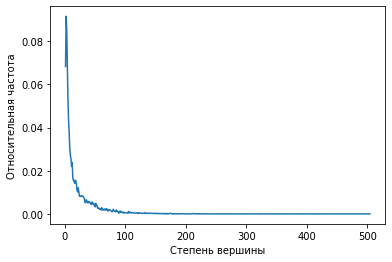

In [ ]:
import matplotlib.pyplot as plt

# Зададим данные по двум осям координат
plt.plot(degrees, relative_frequencies)
plt.xlabel("Степень вершины")       # Метка для оси абсцисс
plt.ylabel("Относительная частота") # Метка для оси ординат
# Отрендерим график и выведем его на экран
plt.show()

А теперь в log-log шкале. Для этого в Matplotlib есть специальный метод:

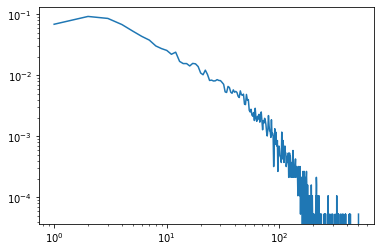

In [ ]:
plt.loglog(degrees, relative_frequencies)
plt.show()

## Исследование изменения доли вершин в наибольшей компоненте связности при удалении некоторого процента вершин в графе

Наконец, попробуем аровести исследование: как меняется доля вершин в наибольшей компоненте слабой связности, если из сети удаляется:
1. случайным образом x% узлов;
2. удаляется x% узлов наибольшей степени.

Для этого сначала построим список вершин нашего графа, отсортированный по степеням в порядке убывания:

In [ ]:
all_nodes_sorted_by_degree, _ = zip(*sorted(G.degree(), key=lambda x: x[1], reverse=True))

Теперь создадим нужные нам функции, принимающие *x* — процент вершин, подлежащих удалению, а возвращающие долю вершин в наибольшей компоненте связности получившегося графа.

Данные функции обе используют метод *remove_nodes_from*, удаляющий вершины, переданные в качестве аргумента, из графа.

In [ ]:
def remove_x_percent_nodes(x):
    """
    Функция, случайным образом удаляющая x% вершин в графе и возвращающая
    долю вершин в наибольшей компоненте связности получившегося графа
    """
    # Создаём копию нашего графа
    H = G.copy()
    # Удаляем вершины из выборки нужного нам размера
    H.remove_nodes_from(sample(all_nodes_sorted_by_degree, round(x*V/100)))
    # Возвращаем долю вершин в наибольшей компоненте связности нового графа
    return len(max(nx.connected_components(H), key=len))/nx.number_of_nodes(H)


def remove_x_percent_largest_degree_nodes(x):
    """
    Функция, удаляющая x% вершин наибольшей степени в графе и возвращающая
    долю вершин в наибольшей компоненте связности получившегося графа
    """
    # Создаём копию нашего графа
    H = G.copy()
    # Удаляем первые [x*V/100] вершин из нашего отсортированного списка
    H.remove_nodes_from(all_nodes_sorted_by_degree[:round(x*V/100)])
    # Возвращаем долю вершин в наибольшей компоненте связности нового графа
    return len(max(nx.connected_components(H), key=len))/nx.number_of_nodes(H)

Теперь приступим к проведению нашего исследования. Предположим, мы хотим отобразить график зависимости нашего *x* от значений вышенаписанных функций.

Для второй функции это будет достаточно просто сделать, так как её значения вычисляются однозначно, то есть мы можем просто прогнать её для различных значений *x* от 0 до 100. 
Давайте сделаем это с единичным шагом:

In [ ]:
# Создаём пустой массив размера 100 для наших долей
LD_LCC_vertices_fractions = np.empty(100)

# Заполняем массив долей значениями нашей функции
for x in range(100):
    LD_LCC_vertices_fractions[x] = remove_x_percent_largest_degree_nodes(x)

А теперь построим наш график с помощью уже знакомой нам библиотеки Matplotlib:

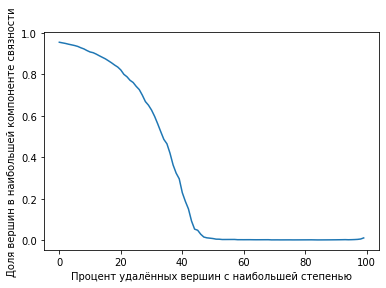

In [ ]:
# Создаём процентный интервал для отображения графиков
percents = np.arange(100)

# Создаём наш график и отображаем его
plt.plot(percents, LD_LCC_vertices_fractions)
plt.xlabel("Процент удалённых вершин с наибольшей степенью")
plt.ylabel("Доля вершин в наибольшей компоненте связности")
plt.show()

Из получившегося графика, во-первых, видно, что наша наибольшая компонента связности изначально составляет практически весь граф, что мы уже могли успеть заметить из наших предыдущих вычислений в самом начале.

Во-вторых, видно, что при удалении из графа уже порядка половины узлов с наибольшими степенями, доля вершин в его наибольшей компоненте становится близка к нулю.

Теперь попробуем построить такой же график, но уже для функции удаления случайных вершин. Чтобы получить хорошую репрезентативность, мы будем вычислять результат несколько раз для каждого *x* и усреднять его.

In [ ]:
# Создаём пустой массив размера 100 для наших долей
R_LCC_vertices_fractions = np.empty(100)
# Установим для начала небольшое количество повторных вычислений
M = 10

# Заполняем массив долей усреднёнными значениями нашей функции
for x in range(100):
    sum_of_fractions = 0
    for _ in range(M):
        sum_of_fractions += remove_x_percent_nodes(x)
    # Берем усреднённый результат
    R_LCC_vertices_fractions[x] = sum_of_fractions/M

Снова построим график для наглядного представления наших результатов:

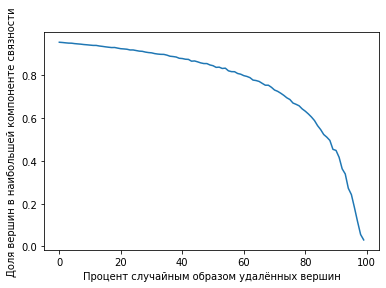

In [ ]:
# Создаём наш график и отображаем его
plt.plot(percents, R_LCC_vertices_fractions)
plt.xlabel("Процент случайным образом удалённых вершин")
plt.ylabel("Доля вершин в наибольшей компоненте связности")
plt.show()

Как видно, мы получили вполне репрезентативный результат даже без большого количества повторных вычислений.

Из полученного графика видно, что мы получили убывание доли вершин в наибольшей компоненте связности пропорциональное логарифму от смещённого и взятого с отрицательным знаком количества удалённых вершин. Для того, чтобы проверить наши догадки, построим другой график.

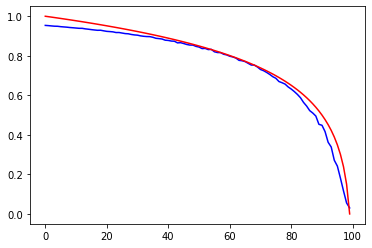

In [ ]:
# Наш исходный график
plt.plot(percents, R_LCC_vertices_fractions, color="blue")
# График логарифма по основанию 100 от 100-x
plt.plot(percents, np.log(100-percents)/np.log(100), color="red")
plt.show()

Интерпретация данного наблюдения оставляется в качестве упражнения читателю :)